In [19]:
import pickle
data = pickle.load(open('all_data.p','rb'))

In [20]:
# ppg = 'stress_likelihood_ppg_no_norm_qual_all_features_weighted'
ppg = 'stress_likelihood_ppg_no_norm_qual_weighted'
ecg = 'stress_likelihood_ecg_weighted'
data = data[[ecg,ppg,'user','day','quality_mag','hand','qual','activity_mag']]
# users = ['bde40f50-8e35-4707-8260-b69f07773c4d','87a2bf88-ef4e-4bd5-96b6-eda8faac6a8e','892e71e0-a5a4-4315-89a4-fa5518d78591','96f6e25f-4dd0-4070-a9ac-b04957969382']
# data = data[~data.user.isin(users)]

In [21]:
import numpy as np
import pandas as pd
data['quality_mag'] = data['quality_mag'].apply(lambda a: .99 if a>=1 else a)
data['quality_mag'] = data['quality_mag'].apply(lambda a:np.floor(a*20)/20)
data['quality_mag'][data.quality_mag>.6] = .6

/cerebralcortex/kessel_jupyter_virtualenv/cc3_high_performance/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [22]:
data['user_day_hand'] = data.apply(lambda a:a['user']+a['day']+a['hand'],axis=1)
data['user_day'] = data.apply(lambda a:a['user']+a['day'],axis=1)
user_day_hand = pickle.load(open('user_day_hand.p','rb'))
# data = data[data.user_day_hand.isin(user_day_hand)]

In [23]:
data.user.unique().shape,data.user_day.unique().shape,data.user_day_hand.unique().shape

((67,), (756,), (1355,))

In [24]:
from sklearn.metrics import r2_score,mutual_info_score,adjusted_mutual_info_score,mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
def KL(P,Q):
    """ Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0. """
    epsilon = 0.0000001

    # You may want to instead make copies to avoid changing the np arrays.
    P = P+epsilon
    Q = Q+epsilon

    divergence = np.mean(P*np.log(P/Q))
    return mean_absolute_error(P,Q)

def get_score(df):
    if df.shape[0]<60:
        return pd.DataFrame([],columns=['user','day','hand','quality','activity','correlation','r2','mutual info','KL divergence','yield'])
    all_data = []
#     if df[[ecg,ppg]].dropna().shape[0]>120:
# #         pass
#         plt.figure(figsize=(20,10))
# #     #     plt.scatter(df['stress_likelihood_ppg_no_norm_qual_weighted'],df['stress_likelihood_ecg'],c=df['quality_mag'])
# #     #     plt.colorbar()
#         plt.plot(df[ppg],'r')
#         plt.plot(df[ecg],'g')
# #     #     plt.plot(df['quality_mag'],'d')
#         plt.show()
#     else:
#         return pd.DataFrame([],columns=['user','day','hand','quality','activity','correlation','r2','mutual info','KL divergence','yield'])
    for q in df.quality_mag.unique():
        for threshold_acl in np.logspace(-2.5,-.2,10):
            df_temp_all = df[(df.quality_mag>=q)&(df.activity_mag<=threshold_acl)&(df.activity_mag>=0.001122018454301963)]
            df_temp = df_temp_all[[ecg,ppg]].dropna()
            if df_temp.shape[0]<20:
                continue
            d  = [df.user.values[0],
                df.day.values[0],
                df.hand.values[0],
                q,
                str(np.round(10000*(threshold_acl/2))/10000)+'g',
                pearsonr(df_temp[ecg],df_temp[ppg])[0],
                r2_score(df_temp[ecg],df_temp[ppg]),
                adjusted_mutual_info_score(np.floor(df_temp[ecg]*10),np.floor(df_temp[ppg]*10)),
                KL(df_temp[ecg].values,df_temp[ppg].values),df_temp_all.shape[0]]
            all_data.append(d)
    return pd.DataFrame(all_data,columns=['user','day','hand','quality','activity','correlation','r2','mutual info','KL divergence','yield'])
from joblib import Parallel,delayed
# score_data = data.groupby(['user','day','hand'],as_index=False).apply(get_score)
score_data = pd.concat(Parallel(n_jobs=-1,verbose=3)(delayed(get_score)(df) for i,df in data.groupby(['user','day','hand'],as_index=False)))
score_data['yield'] = np.int64(score_data['yield'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 416 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 1355 out of 1355 | elapsed:   47.2s finished


In [25]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.median(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, scipy.stats.iqr(a)/2

def get_final(df):
    mean_corr,std_corr = mean_confidence_interval(df['correlation'], confidence=0.99)
    mean_yield,std_yield = mean_confidence_interval(df['yield'], confidence=0.99)
    mean_KL,std_KL = mean_confidence_interval(df['KL divergence'], confidence=0.99)
    show_corr = "{:.2f}".format(mean_corr)+'$\pm$'+"{:.2f}".format(std_corr)
    show_kl = "{:.2f}".format(mean_KL)+'$\pm$'+"{:.2f}".format(std_KL)
    show_yield = "{:.0f}".format(mean_yield)+'$\pm$'+"{:.0f}".format(std_yield)
    return pd.DataFrame([[mean_corr,mean_yield,mean_KL,show_corr,show_kl,show_yield,'>='+str(df.quality.values[0]),
                          '<='+str(df.activity.values[0]),df.hand.values[0]]],
                       columns=['corr','yield','kl','Corr','KL','Yield','quality','activity','hand'])
    
score_tmp = score_data.groupby(['quality','activity'],as_index=False).apply(get_final)

In [26]:
yield_show = pd.pivot_table(score_tmp,columns='quality',index='activity',values='Yield',aggfunc=lambda x:''.join(x))
yield_color = pd.pivot_table(score_tmp,columns='quality',index='activity',values='yield',aggfunc='median')

In [27]:
corr_show = pd.pivot_table(score_tmp,columns='quality',index='activity',values='Corr',aggfunc=lambda x:''.join(x))
corr_color = pd.pivot_table(score_tmp,columns='quality',index='activity',values='corr',aggfunc='median')

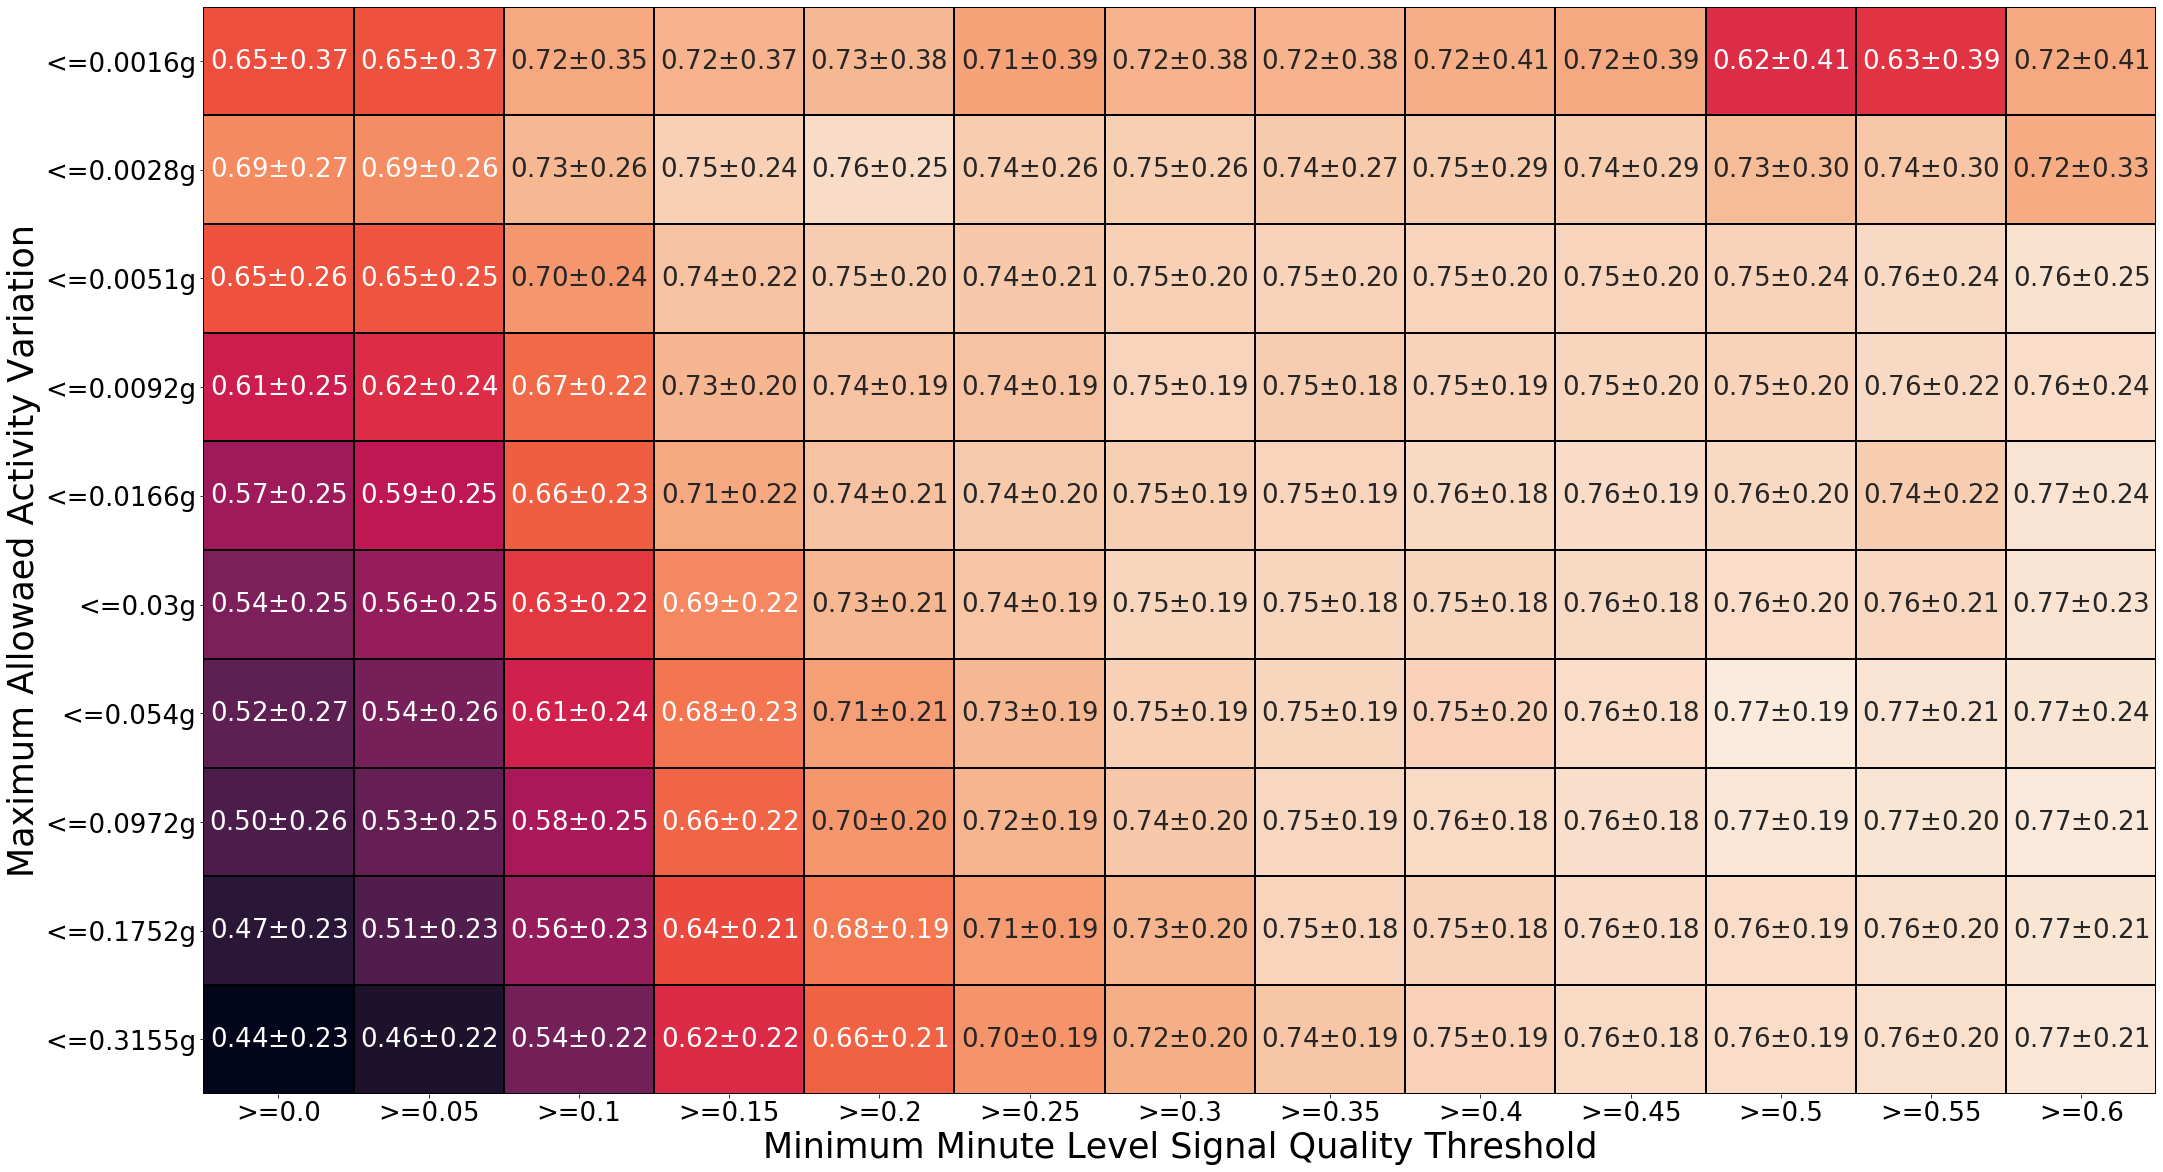

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(35,20))
plt.rcParams.update({'font.size':26})
sns.heatmap(corr_color,annot=corr_show,cmap=None,fmt='',linewidths=1, linecolor='black',cbar=False)
# plt.xticks(np.array(range(len(np.arange(0,.6,.05))))+.5,[np.round(100*a)/100 for a in np.arange(0,.6,.05)],fontsize=40)
# plt.yticks(np.array(range(len(np.logspace(-2.9,-.2,10))))+.5,[str(np.round(10000*(a/2))/10000)+'g' for a in np.logspace(-2.9,-.2,10)],fontsize=40)
plt.xlabel('Minimum Minute Level Signal Quality Threshold',fontsize=35)
plt.ylabel('Maximum Allowaed Activity Variation',fontsize=35)
# plt.title('Yield in Field \n Minutes per day')
# plt.title('Mean Absolute Error of Heart Rate Estimation \n (Ground truth Derived from ECG, Per minute, Unit = ms)',fontsize=35)
# plt.savefig('yield_minutes_per_day.pdf',dps=1e6)
plt.savefig('correlation.pdf',dps=1e6,bbox_inches='tight')
plt.show()

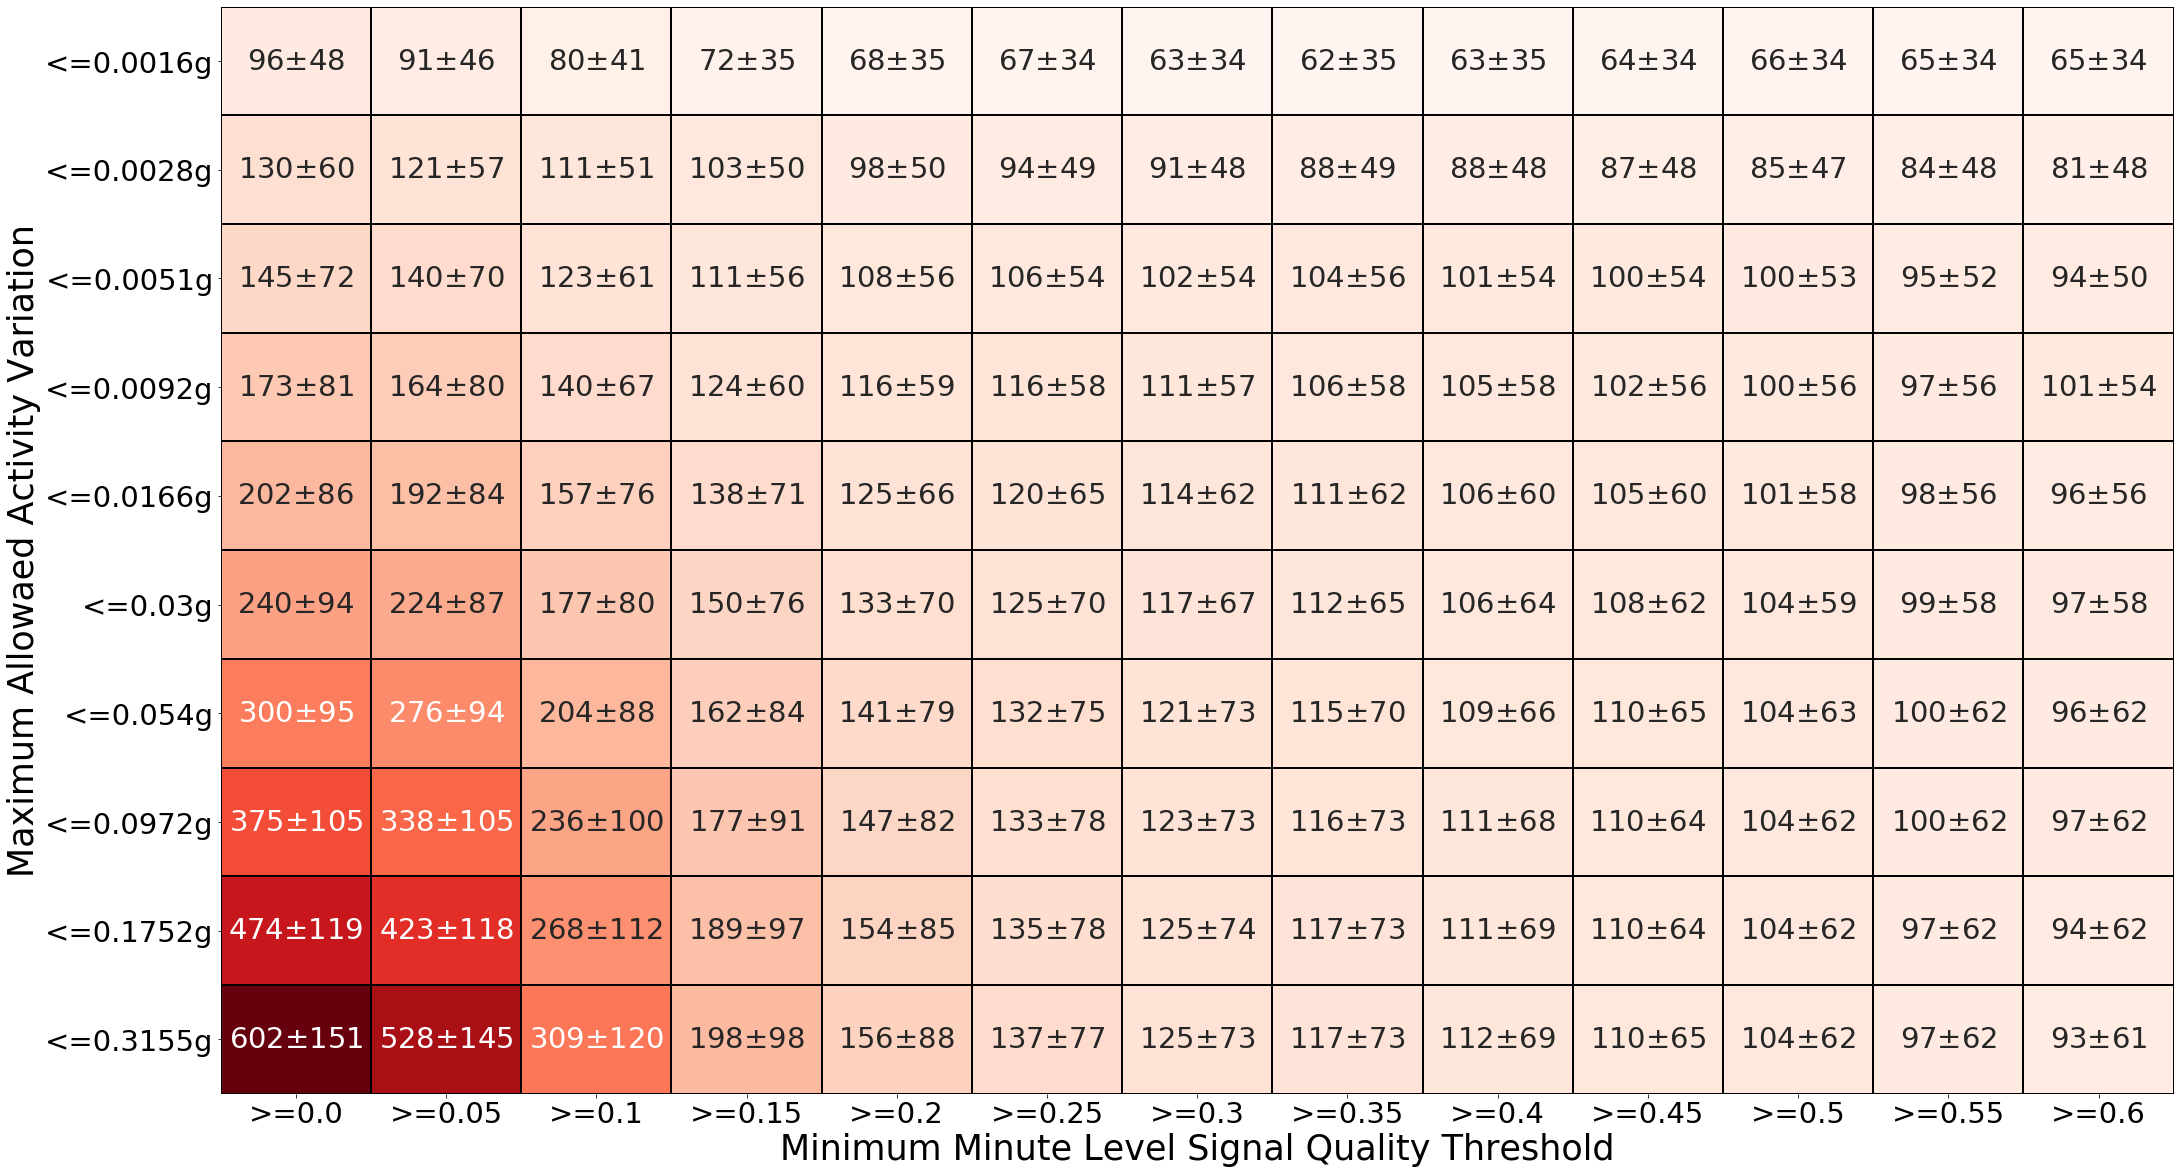

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(35,20))
plt.rcParams.update({'font.size':29})
sns.heatmap(yield_color,annot=yield_show,cmap="Reds",fmt='',linewidths=1, linecolor='black',cbar=False)
# plt.xticks(np.array(range(len(np.arange(0,.6,.05))))+.5,[np.round(100*a)/100 for a in np.arange(0,.6,.05)],fontsize=40)
# plt.yticks(np.array(range(len(np.logspace(-2.9,-.2,10))))+.5,[str(np.round(10000*(a/2))/10000)+'g' for a in np.logspace(-2.9,-.2,10)],fontsize=40)
plt.xlabel('Minimum Minute Level Signal Quality Threshold',fontsize=35)
plt.ylabel('Maximum Allowaed Activity Variation',fontsize=35)
# plt.title('Yield in Field \n Minutes per day')
# plt.title('Mean Absolute Error of Heart Rate Estimation \n (Ground truth Derived from ECG, Per minute, Unit = ms)',fontsize=35)
# plt.savefig('yield_minutes_per_day.pdf',dps=1e6)
plt.savefig('yield_field.pdf',dps=1e6,bbox_inches='tight')
plt.show()

In [ ]:
b = pd.pivot_table(score_tmp,columns='quality',index='activity',values='Yield',aggfunc=lambda x:''.join(x))

In [ ]:
score_tmp2 = score_data.groupby(['quality','activity'],as_index=False).median()

In [18]:
score_tmp[score_tmp.activity=='<=0.3155g'].to_csv('tmp.csv')
# .to_csv('tmp.csv')

In [ ]:
score_tmp[score_tmp.quality=='>=0.0']

In [ ]:
a = pd.pivot_table(score_tmp[score_tmp.hand=='right'],columns='quality',index='activity',values='yield',aggfunc='median')

In [ ]:
a

In [ ]:
10**(-2.95)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(20,10))
g = sns.lineplot(x='quality',y='score',hue='hand',data=score_data)
# plt.ylim([-1,1])
plt.show()

In [ ]:
data[data.quality_mag>=1].user.unique()

In [ ]:
g.get_lines()[1].get_data()

In [ ]:
'$\pm$'

In [ ]:
import pickle
import pandas as pd
import numpy as np

directory_likelihood = '../code_stress/likelihood_threshold_lab_f12.p'
directory_acl = '../code_stress/acl_threshold_lab_f1.p'
results_likelihood = pickle.load(open(directory_likelihood,'rb'))
results_acl = pickle.load(open(directory_acl,'rb'))

def get_f1(results_likelihood,types='likelihood'):
    thresholds = results_likelihood[0][:,:]
    results = np.array([i[0][np.array([3,4,5])] for i in results_likelihood[1]])
    if types=='likelihood':
        thresholds[:,2] =  results[:,0]
    else:
        thresholds[:,0] = thresholds[:,2]
        thresholds[:,2] =  results[:,0]
    return thresholds

data_likelihood = get_f1(results_likelihood,types='likelihood')
data_acl = get_f1(results_acl,types='acl')
data_acl[-2][-1] = .70
# data_likelihood,data_acl

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size':35})
# plt.figure(figsize=(30,15))
fig, ax = plt.subplots(figsize=(30,15))
# ax.scatter(z, y)
ax.plot(data_likelihood[:-3,1],data_likelihood[:-3,2],'*g',linewidth=4,markersize=25,label='Signal Quality Thresholding')
ax.plot(data_acl[:,1],data_acl[:,2],'or',linewidth=4,markersize=25,label='Motion Thresholding')
# ax.plot([109.3953488372093,128.9318181818182],[.696,0.6900584795321637],'or',linewidth=4,markersize=25)

for i, a in enumerate(data_acl[:,:]):
    if abs(a[0]-0.006198800969747552)<.0001:
        continue
    if a[0]<.01:
        ax.annotate("{:.4f}".format(a[0]/2)+'g', (a[1]-10, a[2]-.012),color='brown')
        continue
    if abs(a[0]-0.006198800969747552)<.0001:
        continue
    ax.annotate("{:.3f}".format(a[0]/2)+'g', (a[1]-10, a[2]-.009),color='brown')
# ax.annotate("{:.4f}".format(0.005285388593079247/2)+'g', (109.35-35, .696-.012),color='brown')



for i, a in enumerate(data_likelihood[:-3,:]):
    if .24<a[0]<.26:
        ax.annotate("{:.2f}".format(a[0]), (a[1]-14, a[2]-.011),color='black')
        continue
    if .34<a[0]<.36:
        ax.annotate("{:.2f}".format(a[0]), (a[1]-15, a[2]-.01),color='black')
        continue
    ax.annotate("{:.2f}".format(a[0]), (a[1]+1, a[2]+.004),color='black')
ax.legend(fontsize=40)
ax.set_xlabel('Yield of Data in Field\n (Minutes per participant-wrist day)')
ax.set_ylabel('Stress Model Performance in Lab \n(Leave one subject F1 score)')
plt.savefig('screeing.pdf',bbox_inches='tight')
plt.show()

list(data_acl[:-2,:][-1])

In [ ]:
list([list(a) for a in data_acl])

In [ ]:
list([list(a) for a in data_likelihood])

In [ ]:
data_acl[-2][-1] = .692